In [1]:
import numpy as np
import pandas as pd
import pingouin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from scipy.stats import pearsonr
from collections import Counter
from pingouin import ancova, partial_corr, normality
from matplotlib.colors import ListedColormap
from pickle import dump, load

import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(sklearn.__version__, pingouin.__version__)

c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


1.0 0.5.3


In [2]:
random_state = 0
group = "MCI"
atlas = "AAL1_cropped"

if group == 'CU':
    df = pd.read_csv(f"../results/ADNI/merged_for_dx_prediction_{atlas}_{group}.csv")
    df['DX.n'] = np.where(df['DX.bl'] == 'CN', 1, np.where(df['DX.bl'] == 'SMC', 2, 3))
else:
    df = pd.read_csv(f"../results/ADNI/{group}/merged_for_dx_prediction_{atlas}_{group}.csv")

df = df.dropna(subset=['DX.cat.c'])
df = df.reset_index(drop=True)

# dummy coding of categorical predictors
df['PTAUAB42.cutoff'] = pd.get_dummies(df['PTAU.ABETA42_0.023_cutoff'], drop_first=True)
df['ABETA42.cutoff'] = pd.get_dummies(df['ABETA42_cutoff'], drop_first=True)
df['APOE4'] = np.where(df['APOE4']>0, 1, 0)
df['DX.cat.n'] = pd.get_dummies(df['DX.cat.n'], drop_first=True)

print(f"Condisdering {len(df.index)} {group} participants (n_stable = {df['DX.cat.n'].value_counts()[0]}, n_decline = {df['DX.cat.n'].value_counts()[1]}).")

Condisdering 460 MCI participants (n_stable = 347, n_decline = 113).


In [3]:
colors = {'PET.BAG': 'darkred', 'MRI.BAG': 'midnightblue'}

def plot_pcor(data, group, iv, bag, category, atlas, subcat=""):
    color = colors[bag]
    
    # plot partial correlation
    sns.jointplot(data=data, y=iv, x=bag, color=color, kind="reg",
                  scatter_kws={'alpha': 0.3, 'edgecolor': 'none'},
                  joint_kws={'line_kws': {'linestyle': "--", 'linewidth': 1}})
    plt.savefig(f"../results/ADNI/{group}/{category}/{iv}_{bag}{subcat}_{atlas}.png", bbox_inches="tight", dpi=300)
    plt.close()  
    
def check_pcor(data, group, iv, covar, category, atlas, subcat=""):
    for i in iv:
        print(i)
        normality_i = normality(data=df[i])

        # FDG check normality of variables
        print("FDG-PET BAG")
        normality_fdg = normality(data=data['PET.BAG'])
        
        if normality_i['normal'].values[0] & normality_fdg['normal'].values[0]:
            method_fdg = "pearson"
        else:
            method_fdg = "spearman"
        corr_fdg = partial_corr(data=data, x=i, y="PET.BAG",
                                covar=covar, method=method_fdg)
        print(corr_fdg)
        if corr_fdg['p-val'].values[0] < .1:
            plot_pcor(data, group, i, 'PET.BAG', category, atlas, subcat)
        
        # MRI check normality of variables
        print("MRI BAG: ")
        normality_mri = normality(data=data["MRI.BAG"])
        if normality_i['normal'].values[0] & normality_mri['normal'].values[0]:
            method_mri = "pearson"
        else:
            method_mri = "spearman"

        corr_mri = partial_corr(data=data, x=i, y="MRI.BAG",
                                covar=covar, method=method_mri)
        print(corr_mri)
        if corr_mri['p-val'].values[0] < .1:
            plot_pcor(data, group, i, 'MRI.BAG', category, atlas, subcat)

In [4]:
# PARTIAL CORRELATIONS
covars = ['PTEDUCAT', 'APOE4', 'meanage', 'PTGENDER']  # covariates from ADNI-MEM paper
# COGNITION
cog = ['ADNI_EF', 'ADNI_MEM']

check_pcor(data=df, group=group, iv=cog, covar=covars, category="1_cognitive performance", atlas=atlas)

# NEUROPATHOLOGY
neuropath = ['SUMMARYSUVR_WHOLECEREBNORM', 'ABETA42_recalculated',
            'TAU', 'PTAU', 'PTAU.ABETA42']

check_pcor(data=df, group=group, iv=neuropath, covar=covars, category="1_pathology", atlas=atlas)

ADNI_EF
FDG-PET BAG
           n         r           CI95%         p-val
pearson  460 -0.237727  [-0.32, -0.15]  2.801281e-07
MRI BAG: 
           n         r           CI95%     p-val
pearson  460 -0.225374  [-0.31, -0.14]  0.000001
ADNI_MEM
FDG-PET BAG
            n         r           CI95%    p-val
spearman  460 -0.179125  [-0.27, -0.09]  0.00012
MRI BAG: 
            n         r           CI95%         p-val
spearman  460 -0.397101  [-0.47, -0.32]  1.126132e-18
SUMMARYSUVR_WHOLECEREBNORM
FDG-PET BAG
            n         r          CI95%     p-val
spearman  326  0.056035  [-0.05, 0.16]  0.316159
MRI BAG: 
            n         r         CI95%    p-val
spearman  326  0.095495  [-0.01, 0.2]  0.08711
ABETA42_recalculated
FDG-PET BAG
            n        r           CI95%     p-val
spearman  376 -0.12584  [-0.22, -0.02]  0.015157
MRI BAG: 
            n         r           CI95%     p-val
spearman  376 -0.230316  [-0.32, -0.13]  0.000007
TAU
FDG-PET BAG
            n        r         

FDG-PET BAG:       Source           SS   DF         F     p-unc       np2
0  DX.cat.n    95.843181    1  9.346308  0.002366  0.020128
1  PTEDUCAT     1.202126    1  0.117227  0.732219  0.000258
2     APOE4     4.202522    1  0.409816  0.522385  0.000900
3  PTGENDER    39.643049    1  3.865858  0.049886  0.008425
4  Residual  4665.868761  455       NaN       NaN       NaN
MRI BAG:       Source           SS   DF          F         p-unc       np2
0  DX.cat.n   657.402966    1  66.034264  4.221225e-15  0.126737
1  PTEDUCAT     0.499288    1   0.050152  8.228994e-01  0.000110
2     APOE4     0.486270    1   0.048844  8.251856e-01  0.000107
3  PTGENDER   347.291806    1  34.884477  6.856291e-09  0.071210
4  Residual  4529.744589  455        NaN           NaN       NaN
Mean FDG-PET BAG stables: [0.30563297], mean FDG-PET BAG decliners: [1.3491923].
Mean MRI BAG stables: [1.58252294], mean MRI BAG decliners: [4.50295814].


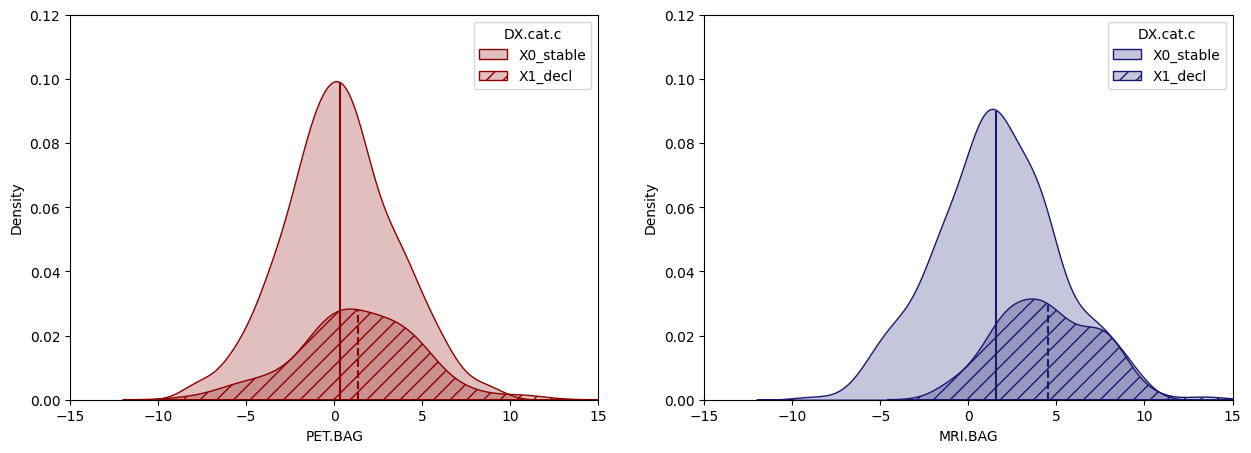

In [5]:
# BAG BASELINE DIFFERENCE (stables vs decliners)
# configure colors for plotting
colors = {'FDG': ['darkred', 'darkred'], 'MRI': ['midnightblue', 'midnightblue']}

# One-way ANCOVA tests of baseline BAG difference as in Lee et al
print("FDG-PET BAG: ", ancova(data=df, dv="PET.BAG", between="DX.cat.n",
                              covar=['PTEDUCAT', 'APOE4', 'PTGENDER']))
print("MRI BAG: ", ancova(data=df, dv="MRI.BAG", between="DX.cat.n",
                              covar=['PTEDUCAT', 'APOE4', 'PTGENDER']))

pet_mean_0 = np.mean(df.loc[df['DX.cat.n'] == 0, ['PET.BAG']])
pet_mean_1 = np.mean(df.loc[df['DX.cat.n'] == 1, ['PET.BAG']])
mri_mean_0 = np.mean(df.loc[df['DX.cat.n'] == 0, ['MRI.BAG']])
mri_mean_1 = np.mean(df.loc[df['DX.cat.n'] == 1, ['MRI.BAG']])
print(f"Mean FDG-PET BAG stables: {pet_mean_0.values}, mean FDG-PET BAG decliners: {pet_mean_1.values}.\nMean MRI BAG stables: {mri_mean_0.values}, mean MRI BAG decliners: {mri_mean_1.values}.")

fig, ax = plt.subplots(1, 2, figsize=(15,5))
# Density plots
kde_pet = sns.kdeplot(data=df, x="PET.BAG", hue="DX.cat.c", palette=colors['FDG'], fill=True, ax=ax[0])
kde_pet.legend_.legend_handles[1].set_hatch("//")
kde_pet.collections[::-1][1].set_hatch("//")
kde_mri = sns.kdeplot(data=df, x="MRI.BAG", hue="DX.cat.c", palette=colors['MRI'], fill=True, ax=ax[1])
kde_mri.legend_.legend_handles[1].set_hatch("//")
kde_mri.collections[::-1][1].set_hatch("//")
ax[0].set_ylim(0, 0.12)
ax[1].set_ylim(0, 0.12)

# Plot means
# Manually adapt height of ymax to max of distribution
ax[0].vlines(pet_mean_0, ymin=0, ymax=0.099, label="mean X0_stable", color=colors['FDG'])  # 0.096
ax[0].vlines(pet_mean_1, ymin=0, ymax=0.028, label="mean X1_decl", color=colors['FDG'], linestyles="--")  # 0.027
ax[1].vlines(mri_mean_0, ymin=0, ymax=0.09, label="mean X0_stable", color=colors['MRI'])  # 0.0855
ax[1].vlines(mri_mean_1, ymin=0, ymax=0.0295, label="mean X1_decl", color=colors['MRI'], linestyles="--")  # 0.028
ax[0].set_xlim(-15, 15)
ax[1].set_xlim(-15, 15)
plt.savefig(f"../results/ADNI/{group}/2_cognitive decline/density_plots_{atlas}.png", bbox_inches="tight", dpi=300)
plt.show()

In [29]:
def check_colinearity(df, cols):
    # Compute correlation matrix between given columns of df dataframe 
    corr = df[cols].corr()
    pval = df[cols].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    corr = corr.round(2).astype(str) + p
    corr.to_csv(f"../results/ADNI/{group}/2_cognitive decline/feature_correlation_{group}.csv")

def cutoff_youdens_j(fpr,tpr,thresholds):
    # Compute a probabbility cutoff to binarize predictions of cognitive outcome 
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

def cognitive_outcome(df_init, feature_names, calibrate_probs=False, print_cutoffs=False, save_classifier=False):    
    # Train and validate a logistic regression classifier for the prediction of cognitive outcome
    # Define covariates. Don't correct for age if age is among predictors
    covar_names = ['PTEDUCAT', 'APOE4', 'PTGENDER']

    # Remove NA values
    df = df_init.copy().dropna(subset=feature_names+covar_names+["DX.cat.n"])
    print(f"{len(df.index)} subjects with full information.")
    
    # Split the data into features, target and covariates (for residual creation)
    X = df[feature_names]
    y = df['DX.cat.n']
    covars = df[covar_names]
    
    # Create the logistic regression model
    clf = LogisticRegression(max_iter=1000, random_state=random_state)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    predictions = {'GT': [], 'PROBA': [], 'VAL': [], 'PRED': [], 'PRED2': [], 'PRED3': []} 
    history = {'auc': [], 'sens': [], 'spec': [], 'cutoff': []}
    for i, (train_idx, val_idx) in enumerate(cv.split(X,y)):
        X_train, X_val = X.values[train_idx], X.values[val_idx]
        y_train, y_val = y.values[train_idx], y.values[val_idx]
        covar_train, covar_val = covars.iloc[train_idx], covars.iloc[val_idx]
    
        # Fit GLM to controls of training data to create residuals
        # (control for age, sex, years of edu and APOE)
        X_train_controls = X_train[y_train==0]
        frequency_cutoff = 1-X_train_controls.shape[0]/X_train.shape[0]
        covar_train_controls = covar_train[y_train==0]
        glm = LinearRegression()
        # fit GLM on controls of train set
        glm.fit(covar_train_controls, X_train_controls)
        # compute correction of X for covars
        X_train_pred = glm.predict(covar_train)
        # create residuals
        X_train_res = X_train - X_train_pred
        # standardize residuals
        scaler = StandardScaler()
        X_train_stdres = scaler.fit_transform(X_train_res)
        
        # compute correction of X for covars
        X_val_pred = glm.predict(covar_val)
        # create residuals
        X_val_res = X_val - X_val_pred
        # standardize residuals USING TRAIN PARAMETERS
        X_val_stdres = scaler.transform(X_val_res)

        # Fit the estimator on the training data for this fold
        clf.fit(X_train_stdres, y_train)

        # Calibration of posterior probabilities
        if calibrate_probs:
            clf = CalibratedClassifierCV(clf)
            clf.fit(X_train_stdres, y_train)
        
        # Store residual model, residual scaler and prediction model
        if save_classifier:
            dump(glm, open(f"../results/0_FINAL_MODELS/CO_resglm_{group}_{atlas}_{i}.p", "wb"))
            dump(scaler, open(f"../results/0_FINAL_MODELS/CO_resscaler_{group}_{atlas}_{i}.p", "wb"))
            dump(clf, open(f"../results/0_FINAL_MODELS/CO_prediction_{group}_{atlas}_{i}.p", "wb"))

        y_pred_prob = clf.predict_proba(X_val_stdres)[:, 1]
        y_pred = clf.predict(X_val_stdres)
        
        # Save standardized residuals, ground truth and probability prediction
        predictions['VAL'].append(X_val_stdres)
        predictions['GT'].append(y_val)
        predictions['PROBA'].append(y_pred_prob)
        predictions['PRED'].append(y_pred)

        # Calculate and store performance metrics
        # Avoid UndefinedMetricWarning if no individuals are predicted to decline (label 1)
        history['auc'].append(roc_auc_score(y_val, y_pred_prob))
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
        cutoff = cutoff_youdens_j(fpr, tpr, thresholds)
        history['cutoff'].append(cutoff)
        predictions['PRED2'].append(np.where(y_pred_prob>cutoff, 1, 0))
        predictions['PRED3'].append(np.where(y_pred_prob>frequency_cutoff, 1, 0))
        if 1 in y_pred:
            rep = classification_report(y_val, predictions['PRED3'], output_dict=True)
            history['sens'].append(rep['1']['recall'])
            history['spec'].append(rep['0']['recall'])
        else:
            history['sens'].append(np.nan)
            history['spec'].append(np.nan)
        
        
        
        if print_cutoffs:
            print("Probability cut-off: ", cutoff)
            print("Corresponds to true threshold: ", X_val[y_pred_prob == cutoff][0][0])
    
    print(f"AUC: {np.mean(history['auc'])}, Sensitivity: {np.nanmean(history['sens'])}, Specificity: {np.nanmean(history['spec'])}")
    print(f"{np.isnan(history['sens']).sum()} folds did not contain any positive class predictions.\n")

    return predictions, history

def predict_cognitive_outcome(df_init, feature_names, cutoffs):
    # Define covariates. Don't correct for age if age is among predictors
    covar_names = ['PTEDUCAT', 'APOE4', 'PTGENDER']

    # Remove NA values
    df = df_init.copy().dropna(subset=feature_names+covar_names+["DX.cat.n"])
    
    # Split the data into features, target and covariates (for residual creation)
    X = df[feature_names]
    y = df['DX.cat.n']
    covars = df[covar_names]

    for i in range(10):
        if i == 0:
            print(f"{len(df.index)} subjects with full information.")
        resglm = load(open(f"../results/0_FINAL_MODELS/CO_resglm_{group}_{atlas}_{i}.p", "rb"))
        
        # compute correction of X for covars
        X_pred = resglm.predict(covars)
        # create residuals
        X_res = X - X_pred
        # standardize residuals USING TRAIN PARAMETERS
        resscaler = load(open(f"../results/0_FINAL_MODELS/CO_resscaler_{group}_{atlas}_{i}.p", "rb"))
        X_stdres = resscaler.transform(X_res.values)

        # predict probability of change in diagnosis
        clf = load(open(f"../results/0_FINAL_MODELS/CO_prediction_{group}_{atlas}_{i}.p", "rb"))
        y_pred_proba = clf.predict_proba(X_stdres)[:, 1]
        
        # Store results in dataframe
        df['PROBA_'+str(i)] = y_pred_proba

        # Apply cutoff (same as calling ".predict(X)")
        df['CO_'+str(i)] = np.where(df['PROBA_'+str(i)]>cutoffs[i], 1, 0)
    
    # Majority voting for cognitive outcome
    # Compute the mode of each row for the selected columns using mode()
    df['CO_final'] = df.filter(regex='^CO').mode(axis=1)[0]
    rep = classification_report(df['DX.cat.n'], df['CO_final'], output_dict=True)

    # Report AUC of mean probabilities across folds
    print("AUC with mean probabilities: ", roc_auc_score(df['DX.cat.n'], df.filter(regex='^PROBA').mean(axis=1)))
    print(f"Sensitivity: {rep['1.0']['recall']}, Specificity: {rep['0.0']['recall']}")
    return df

PET.BAG
460 subjects with full information.


UnboundLocalError: local variable 'cutoff' referenced before assignment

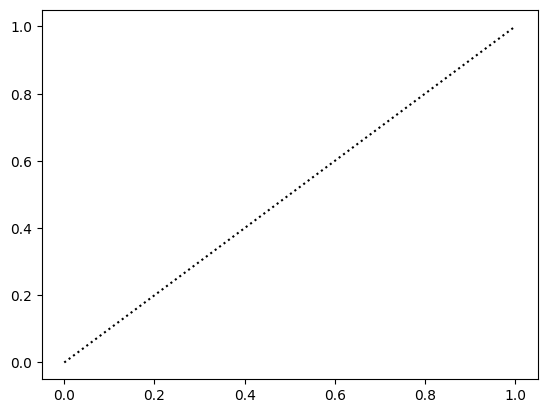

In [30]:
calibrate_probs = False

# Assess all numeric single features as predictors of cognitive outcome
single_feature_probabilities = {}
single_feature_gt = {}
singlefeatures = ['PET.BAG', 'MRI.BAG', 'Hippocampus_GMV', 'SUMMARYSUVR_WHOLECEREBNORM', 'Precuneus_SUVR', 'PTAU.ABETA42', 'ADNI_MEM', 'meanage']  # 'ABETA42.40': not enough observations
# Create new colormap, where PET and MRI BAG keep their previously used colors
colors = ['darkred', 'midnightblue'] + [plt.cm.viridis(i) for i in np.linspace(0, 1, len(singlefeatures)-2)]
cmap = ListedColormap(colors)
fig = plt.figure()
plt.plot([0, 1], linestyle="dotted", color="black")
for f in singlefeatures:
    if f == 'PET.BAG' or f == 'MRI.BAG':
        linewidth = 3  # plot BAG thicker
        alpha = 1  # plot BAG non-transparent
        zorder = 1 # plot BAG on top of plot
    else:
        linewidth = 1.2  # plot other vars thinner
        alpha = 0.7  # increase transparency of other vars
        zorder = 0  # plot other vars at lower level of layers
    print(f)
    co = cognitive_outcome(df, [f], calibrate_probs=calibrate_probs)
    single_feature_probabilities[f] = [item_ for sublist in co[0]['PROBA'] for item_ in sublist]
    single_feature_gt[f] = [item_ for sublist in co[0]['GT'] for item_ in sublist]
    fpr, tpr, threshold = roc_curve(single_feature_gt[f], single_feature_probabilities[f])
    plt.plot(fpr, tpr, label=f, color=cmap(singlefeatures.index(f)), linewidth=linewidth,
             alpha=alpha, zorder=zorder)

plt.title("Single feature prediction of cognitive outcome")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.legend(fontsize=8)
plt.savefig(f"../results/ADNI/{group}/2_cognitive decline/AUC_biomarker_comparison_{atlas}.png", bbox_inches="tight")
plt.show()

460 subjects with full information.
AUC: 0.7504469060351414, Sensitivity: 0.19393939393939394, Specificity: 0.9339495798319328
0 folds did not contain any positive class predictions.

Cutoff employed by LogR is Youden cutoff:  False
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       347
           1       0.42      0.71      0.53       113

    accuracy                           0.69       460
   macro avg       0.65      0.69      0.65       460
weighted avg       0.76      0.69      0.71       460

[[236 111]
 [ 33  80]]


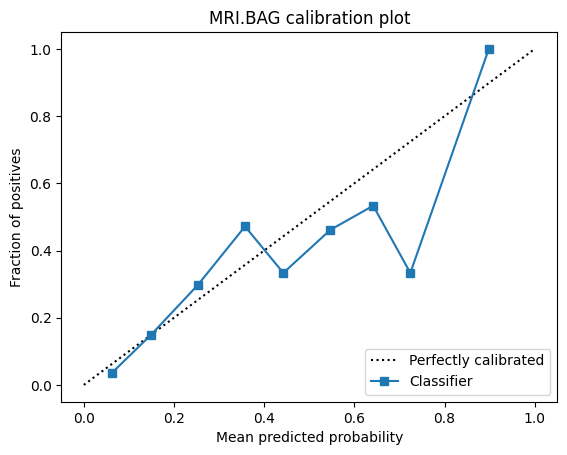

In [28]:
# Get model with significant BAG
sig_bag = 'MRI.BAG'
sig_bag_lr = cognitive_outcome(df, [sig_bag], calibrate_probs=False, save_classifier=True)
ground_truth = [item_ for sublist in sig_bag_lr[0]['GT'] for item_ in sublist]
proba = [item_ for sublist in sig_bag_lr[0]['PROBA'] for item_ in sublist]
val = [item_[0] for sublist in sig_bag_lr[0]['VAL'] for item_ in sublist]
pred = [item_ for sublist in sig_bag_lr[0]['PRED'] for item_ in sublist]  # model cutoff
pred2 = [item_ for sublist in sig_bag_lr[0]['PRED2'] for item_ in sublist]  # Youden cutoff
pred3 = [item_ for sublist in sig_bag_lr[0]['PRED3'] for item_ in sublist]  # Sample cutoff
print("Cutoff employed by LogR is Youden cutoff: ", pred == pred2)

print(classification_report(ground_truth, pred3))
print(confusion_matrix(ground_truth, pred3))

fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(ground_truth, proba, n_bins=10, ax=ax)

ax.set_title(f"{sig_bag} calibration plot")
plt.show()

In [221]:
# Get cutoff and apply to DELCODE
cutoffs_sig_bag = sig_bag_lr[-1]['cutoff']
print(f"""Probability cutoffs for increased risk of cognitive deterioration, range:
      [{np.min(cutoffs_sig_bag)}, {np.max(cutoffs_sig_bag)}].
      Mean: {np.mean(cutoffs_sig_bag)}, median: {np.median(cutoffs_sig_bag)}""")

Probability cutoffs for increased risk of cognitive deterioration, range:
      [0.3154123384840619, 0.6834083603505139].
      Mean: 0.490302878120327, median: 0.5120099333158515


In [222]:
delcode = pd.read_csv(f"../results/DELCODE/{group}/merged_for_dx_prediction_{atlas}_{group}.csv")
delcode = predict_cognitive_outcome(delcode, [sig_bag], cutoffs_sig_bag)
print(classification_report(delcode['DX.cat.n'], delcode['CO_final']))
print(confusion_matrix(delcode['DX.cat.n'], delcode['CO_final']))

68 subjects with full information.
AUC with mean probabilities:  0.7580357142857143
Sensitivity: 0.6785714285714286, Specificity: 0.65
              precision    recall  f1-score   support

         0.0       0.74      0.65      0.69        40
         1.0       0.58      0.68      0.62        28

    accuracy                           0.66        68
   macro avg       0.66      0.66      0.66        68
weighted avg       0.67      0.66      0.66        68

[[26 14]
 [ 9 19]]
